# Wiener Filtering

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]

In [2]:
m_lichen = lim('Lichen',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [45]:
m_lichen.update(tobs=2000*u.hr)

In [46]:
k_sim = m_lichen.k_sim
Pk_sim = m_lichen.Pk_sim

Loading .npz catalogues...


In [47]:
Pnoise = m_lichen.Pnoise
k_noise = k_sim

In [48]:
P_noise = [0 for i in range(len(k_sim))]
for i in range(len(k_sim)):
    P_noise[i] = Pnoise.value
P_noise = np.array(P_noise)

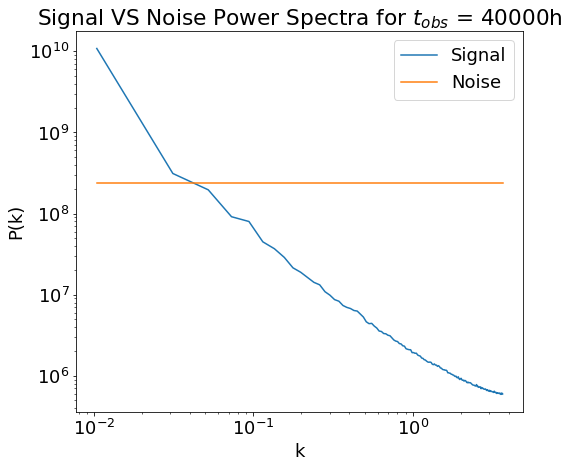

In [7]:
plt.plot(k_sim, Pk_sim, label = 'Signal')
plt.plot(k_noise, P_noise, label = 'Noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title(r'Signal VS Noise Power Spectra for $t_{obs}$ = 40000h')
plt.legend()

In [8]:
from limlam_mocker.limlam_mocker import redshift_to_chi as rtc
from limlam_mocker.limlam_mocker import load_peakpatch_catalogue_cosmo as lppcc

### Computing the Power Spectrum from the Measured Map 

code from `limlam_mocker.limlam_mocker.map_to_pspec()`

In [49]:
x,y,z = m_lichen.mapinst.pix_binedges_x, m_lichen.mapinst.pix_binedges_y, m_lichen.mapinst.nu_binedges
t     = m_lichen.noise_added_map

In [50]:
cosmo = lppcc(m_lichen.halo_info)

In [51]:
zco   = rtc(m_lichen.mapinst.nu_rest/z-1, cosmo)

In [52]:
avg_ctd = np.mean(zco)
xco     = x/(180)*np.pi*avg_ctd
yco     = y/(180)*np.pi*avg_ctd

In [53]:
dxco, dyco, dzco = [np.abs(np.mean(np.diff(d))) for d in (xco, yco, zco)]
Pk_3D            = np.abs(np.fft.rfftn(t)*dxco*dyco*dzco)**2/np.abs(np.ptp(xco)*np.ptp(yco)*np.ptp(zco))

In [54]:
kx        = 2*np.pi*np.fft.fftfreq(xco.size - 1, d = dxco)
ky        = 2*np.pi*np.fft.fftfreq(yco.size - 1, d = dyco)
kz        = 2*np.pi*np.fft.rfftfreq(zco.size - 1, d = dzco)

In [55]:
kgrid     = np.sqrt(sum(ki**2 for ki in np.meshgrid(kx, ky, kz, indexing = 'ij')))
dk        = max(np.diff(kx)[0], np.diff(ky)[0], np.diff(kz)[0])

In [56]:
kmax_dk   = int(np.ceil(max(np.amax(kx), np.amax(ky), np.amax(kz))/dk))
kbins     = np.linspace(0, kmax_dk*dk, kmax_dk + 1)

In [57]:
Pk_nmodes = np.histogram(kgrid[kgrid > 0], bins = kbins, weights = Pk_3D[kgrid > 0])[0]
nmodes    = np.histogram(kgrid[kgrid > 0], bins = kbins)[0]

In [58]:
Pk_m = Pk_nmodes/nmodes
k_m  = (kbins[1:] + kbins[:-1])/2

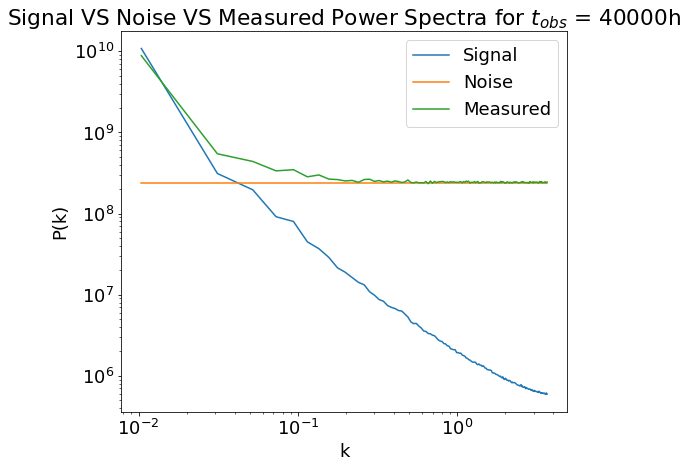

In [19]:
plt.plot(k_sim, Pk_sim, label = 'Signal')
plt.plot(k_noise, P_noise, label = 'Noise')
plt.plot(k_m, Pk_m, label = 'Measured')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title(r'Signal VS Noise VS Measured Power Spectra for $t_{obs}$ = 40000h')
plt.legend()

In [59]:
P_new = ((Pk_sim.value)/(Pk_sim.value + P_noise))*(Pk_m)

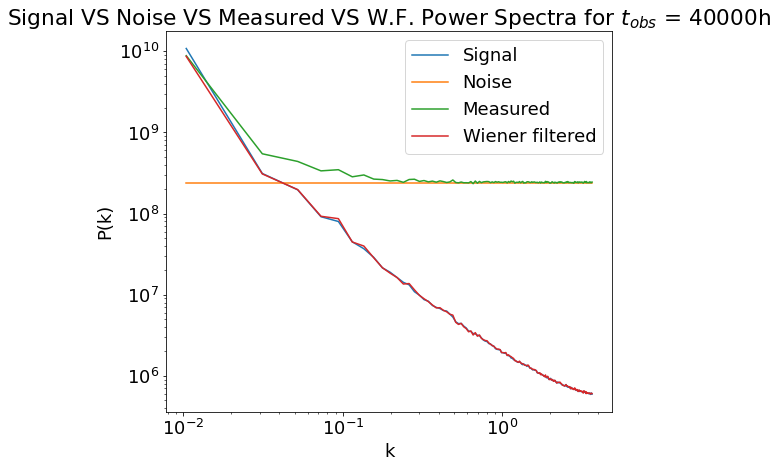

In [21]:
plt.plot(k_sim, Pk_sim, label = 'Signal')
plt.plot(k_noise, P_noise, label = 'Noise')
plt.plot(k_m, Pk_m, label = 'Measured')
plt.plot(k_m, P_new, label = 'Wiener filtered')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title(r'Signal VS Noise VS Measured VS W.F. Power Spectra for $t_{obs}$ = 40000h')
plt.legend()

## Retrieving the signal

In [22]:
from scipy import interpolate

In [60]:
W_k = Pk_sim.value/(Pk_sim.value + P_noise)

In [61]:
interp = interpolate.interp1d(k_m, W_k, fill_value = 'extrapolate')

In [62]:
new_t = np.fft.rfftn(t)*interp(kgrid)

In [63]:
new_map = np.fft.irfftn(new_t)

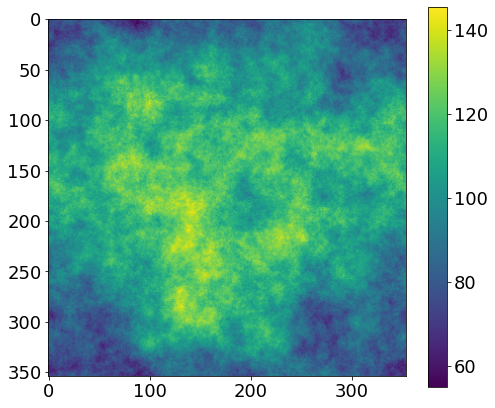

In [64]:
plt.imshow(new_map[...,3])
plt.colorbar()

In [40]:
from scipy.ndimage import gaussian_filter

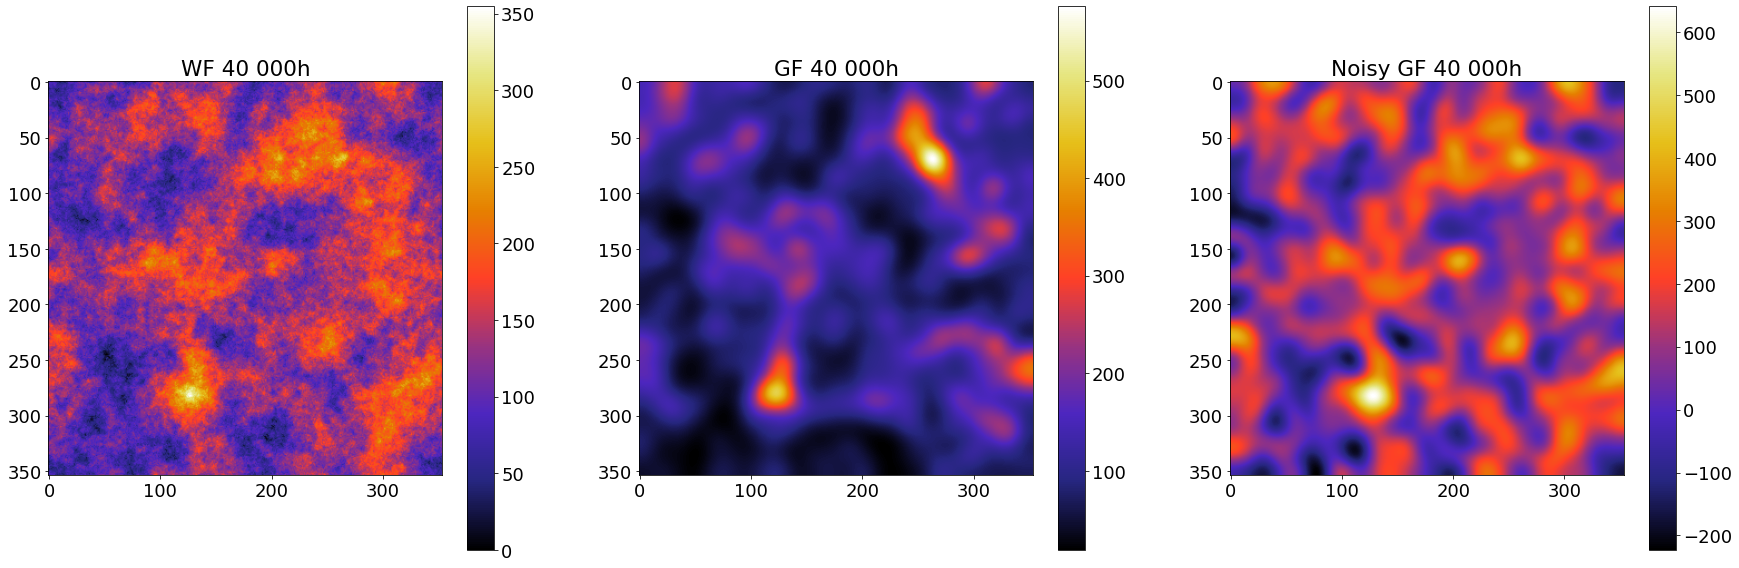

In [44]:
fig , axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

plt.subplot(131)
plt.imshow(new_map[...,3], cmap = 'CMRmap') 
plt.title('WF 40 000h') 
plt.colorbar()

plt.subplot(132)
plt.imshow(gaussian_filter(m_lichen.maps[...,3], 10), cmap = 'CMRmap') 
plt.title('GF 40 000h')
plt.colorbar()

plt.subplot(133)
plt.imshow(gaussian_filter(m_lichen.noise_added_map[...,3], 10), cmap = 'CMRmap') 
plt.title('Noisy GF 40 000h')
plt.colorbar()

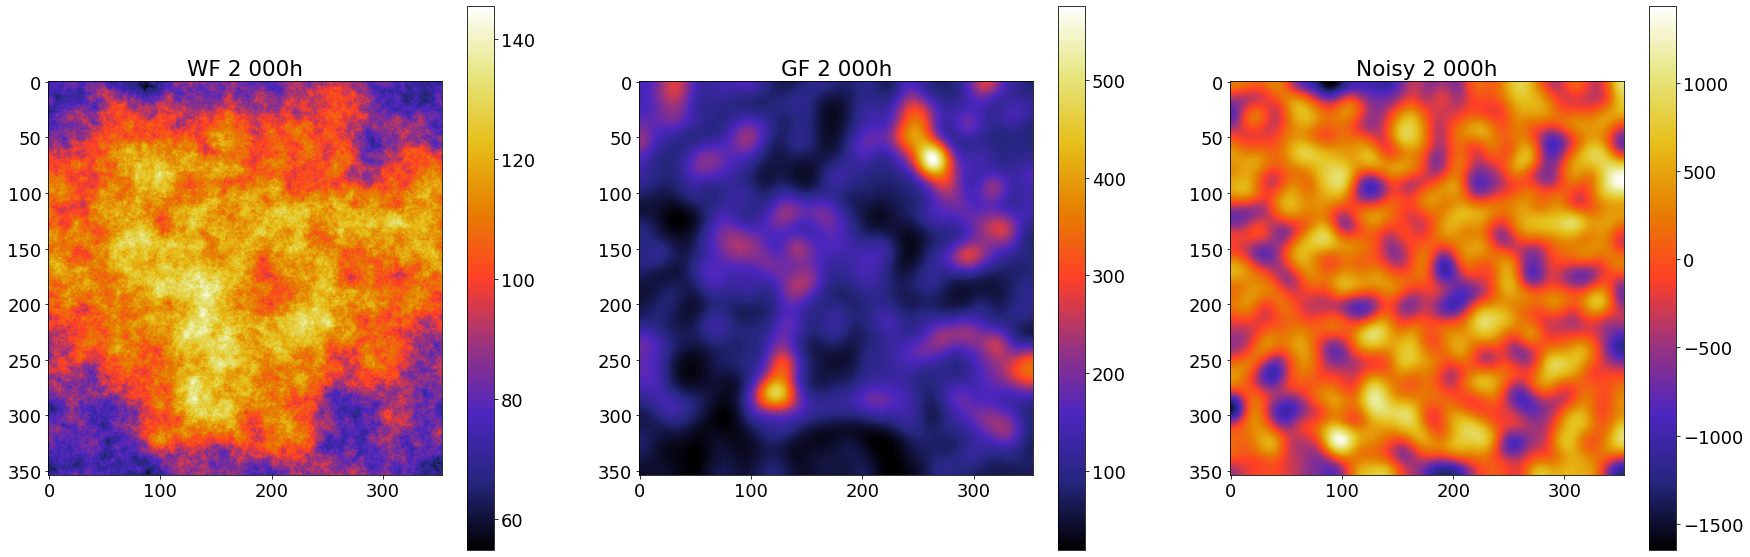

In [66]:
fig , axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

plt.subplot(131)
plt.imshow(new_map[...,3], cmap = 'CMRmap') 
plt.title('WF 2 000h') 
plt.colorbar()

plt.subplot(132)
plt.imshow(gaussian_filter(m_lichen.maps[...,3], 10), cmap = 'CMRmap') 
plt.title('GF 2 000h')
plt.colorbar()

plt.subplot(133)
plt.imshow(gaussian_filter(m_lichen.noise_added_map[...,3], 10), cmap = 'CMRmap') 
plt.title('Noisy 2 000h')
plt.colorbar()

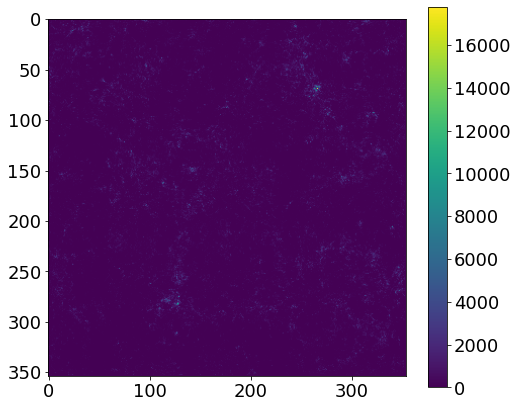

In [31]:
plt.imshow(m_lichen.maps[...,3])
plt.colorbar()

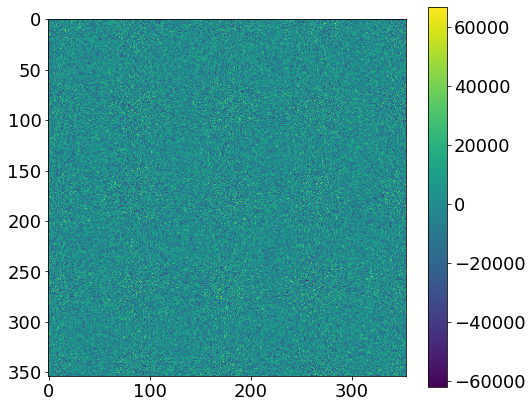

In [239]:
plt.imshow(m_lichen.noise_added_map[...,3])
plt.colorbar()